# 自動價格趨勢線  

## 程式實作：自動價格趨勢線函式  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mplfinance as mpf
import numpy as np

In [2]:
# 來源 ： https://github.com/neurotrader888/TechnicalAnalysisAutomation/blob/main/trendline_automation.py
from myutils.TrendlineAutomation import fit_trendlines_single
from myutils.TrendlineAutomation import fit_trendlines_high_low

In [3]:
def FitTrendlines(prices, mode = 'close') :
    # 價格資料確認與處理
    if prices is None and type(prices) is not DataFrame:
        return None
    in_prices = prices.copy()
    if 'Open' not in in_prices.columns or 'High' not in in_prices.columns or 'Low' not in in_prices.columns or 'Close' not in in_prices.columns :
        return None    
    if 'Date' not in in_prices.columns and in_prices.index.dtype == 'datetime64[ns]' :
        in_prices.index.name = 'Date'
        in_prices = in_prices.reset_index()
    if 'Date' not in in_prices.columns :
        return None
    # 模式確認與處理
    prices_close=np.array(in_prices['Close'])
    if mode == 'close' :
        pass
    elif mode == 'high_low' :
        prices_high=np.array(in_prices['High'])
        prices_low=np.array(in_prices['Low'])
    else :
        return None
    # 擬合趨勢線
    if mode == 'close' :
        trendlines = fit_trendlines_single(prices_close)
    elif mode == 'high_low' :
        trendlines = fit_trendlines_high_low(prices_high,prices_low,prices_close)
    # 輸出格式處理
    trendline_start_index = in_prices.iloc[0].name
    trendline_end_index = in_prices.iloc[-1].name
    trendline_start_date = in_prices.iloc[0]['Date'].strftime('%Y-%m-%d')
    trendline_end_date = in_prices.iloc[-1]['Date'].strftime('%Y-%m-%d')
    support_slope  = trendlines[0][0]
    support_intercept = trendlines[0][1]
    support_trendline_start_price = support_slope * trendline_start_index + support_intercept
    support_trendline_end_price = support_slope * trendline_end_index + support_intercept
    resist_slope = trendlines[1][0]
    resist_intercept = trendlines[1][1]
    resist_trendline_start_price = resist_slope * trendline_start_index + resist_intercept
    resist_trendline_end_price = resist_slope * trendline_end_index + resist_intercept
    # 回傳資料處理
    ret_trendlines =  [[(trendline_start_date,support_trendline_start_price),(trendline_end_date,support_trendline_end_price)],
                       [(trendline_start_date,resist_trendline_start_price),(trendline_end_date,resist_trendline_end_price)]]
    return (trendlines,ret_trendlines)

## 程式實作：利用自動趨勢線函式繪製的趨勢線

In [4]:
##### 使用2022年9月5日到2023年8月4日的日K線資料繪製 #####

# 載入從「好神通PLUS」輸出的Excel檔
df = pd.read_excel('Day11.xlsx')

# 保存K線的基本資訊(開、高、低、收、量)
df_k_line = df.drop(columns=['SMA5','SMA10','SMA20','SMA60','SMA120','SMA240','MA5','MA10', 'DIF12-26','MACD9','OSC','K(9,3)','D(9,3)'])

# 保存價的移動平均線
df_sma = df.drop(columns=['開盤價','最高價','最低價','收盤價','成交量','MA5','MA10', 'DIF12-26','MACD9','OSC','K(9,3)','D(9,3)']) 

# 將K線的Columns的名稱由中文改為英文
df_k_line = df_k_line.rename(columns={'時間':'Date','開盤價':'Open','最高價':'High','最低價':'Low','收盤價':'Close','成交量':'Volume'})

# 將價的移動平均線的Columns的名稱由中文改為英文
df_sma = df_sma.rename(columns={'時間':'Date'})

# 將K線的Date設為Index
df_k_line.set_index(df_k_line['Date'],inplace=True)
df_k_line = df_k_line.drop(columns=['Date'])

# 將價的移動平均線的Date設為Index
df_sma.set_index(df_sma['Date'],inplace=True)
df_sma = df_sma.drop(columns=['Date'])

In [5]:
# 擷取區間並抽取收盤價
df_k_line_test = df_k_line['2022-10-25':]
prices_close = np.array(df_k_line_test['Close'])

# 在收盤價區間擬合出支撐與壓力趨勢線
_,trendlines = FitTrendlines(df_k_line['2022-10-25':])
print(trendlines)

# 上升趨勢看支撐不看壓力，所以刪除壓力線
trendlines = trendlines[0]
print(trendlines)

[[('2022-10-25', 12666.12), ('2023-08-04', 16694.42862446265)], [('2022-10-25', 14511.173806483592), ('2023-08-04', 17948.242169466383)]]
[('2022-10-25', 12666.12), ('2023-08-04', 16694.42862446265)]


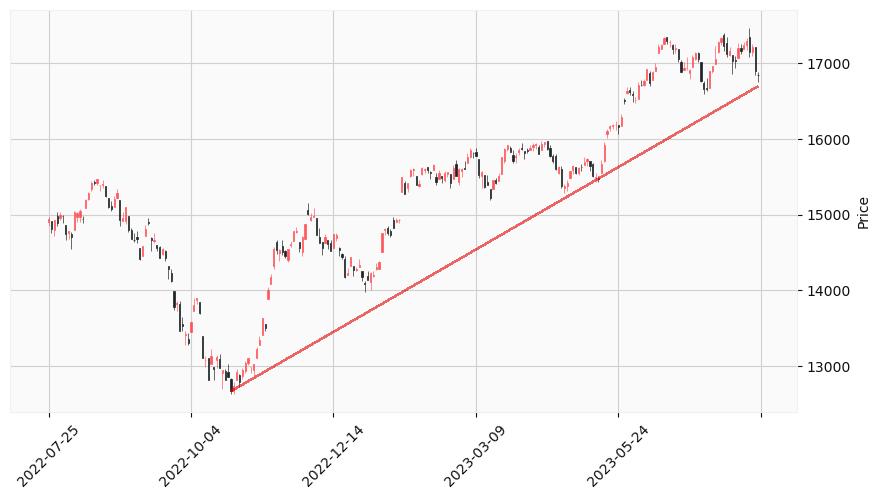

In [6]:
# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定支撐線與壓力線
seq_of_seq_of_points=trendlines

# 繪出K線圖
kwargs = dict(type='candle', style=s, figratio=(19,10), alines=dict(alines=seq_of_seq_of_points, linewidths=1.0, colors='xkcd:red', alpha=0.6), datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)

#### 對照組：尋找K線圖上的轉折點後，人工方式選擇轉折點以繪製直線趨勢線

                Date     Price Type
DateIndex                          
8         2022-08-04  14702.20   LO
17        2022-08-17  15465.45   HI
32        2022-09-07  14410.05   LO
35        2022-09-13  14894.41   HI
64        2022-10-25  12666.12   LO
91        2022-12-01  15012.80   HI
111       2022-12-29  14085.02   LO
135       2023-02-14  15654.48   HI
141       2023-02-22  15418.77   LO
148       2023-03-07  15857.89   HI
155       2023-03-16  15221.12   LO
174       2023-04-17  15963.55   HI
180       2023-04-25  15370.73   LO
189       2023-05-09  15727.70   HI
193       2023-05-15  15475.05   LO
216       2023-06-15  17334.98   HI
222       2023-06-27  16887.90   LO
227       2023-07-04  17140.77   HI
231       2023-07-10  16652.80   LO
236       2023-07-17  17334.29   HI
240       2023-07-21  17030.70   LO
245       2023-07-28  17292.93   HI


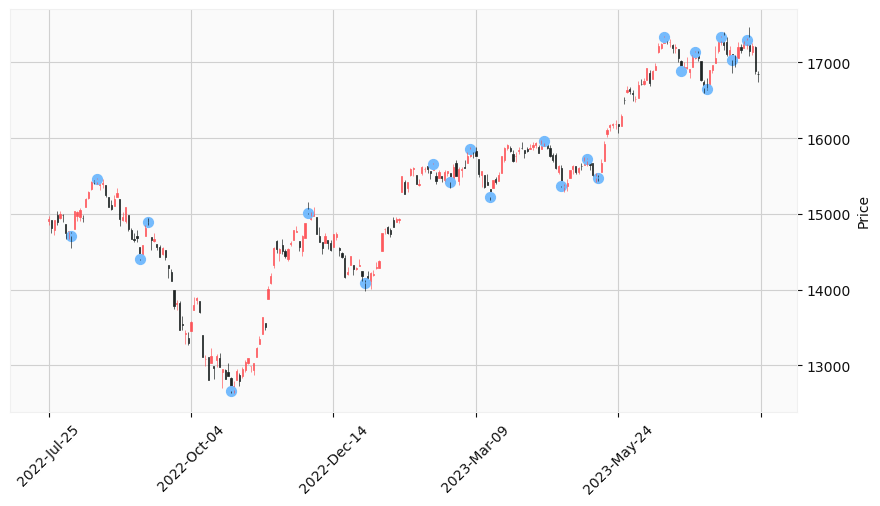

In [7]:
import myutils

# 尋找轉折點
_,_,max_min = myutils.FindingTurningPoints(df_k_line,'close',order=5)
print(max_min)

# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定轉折點    
turning_points_len = len(np.array(df_k_line['Close']))
turning_points = np.array([np.nan]*turning_points_len)
for point in max_min.iterrows() :
    turning_points[point[0]] = point[1]['Price']    
apds = [
    mpf.make_addplot(turning_points,type='scatter',marker='o',markersize=50,color='xkcd:sky blue')
]

# 繪出K線圖
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds)
mpf.plot(df_k_line,**kwargs)

In [8]:
def date_to_index(df_in,date_in) :
    number_array = df_in.index == date_in
    idx = 0
    for number_index in number_array :
        if number_index == True :
            break
        idx = idx + 1
    return idx

In [9]:
# 設定上升趨勢線：目視轉折點已設定趨勢線
trendline_up_x = [64,193]
trendline_up_y = [max_min.loc[trendline_up_x[0]]['Price'],max_min.loc[trendline_up_x[1]]['Price']]
slope,intercept = np.polyfit(trendline_up_x,trendline_up_y,1)
trendline_up_start_date = '2022-10-25'
trendline_up_start_price = slope * date_to_index(df_k_line,'2022-10-25') + intercept
trendline_up_end_date = '2023-08-04'
trendline_up_end_price = slope * date_to_index(df_k_line,'2023-08-04') + intercept

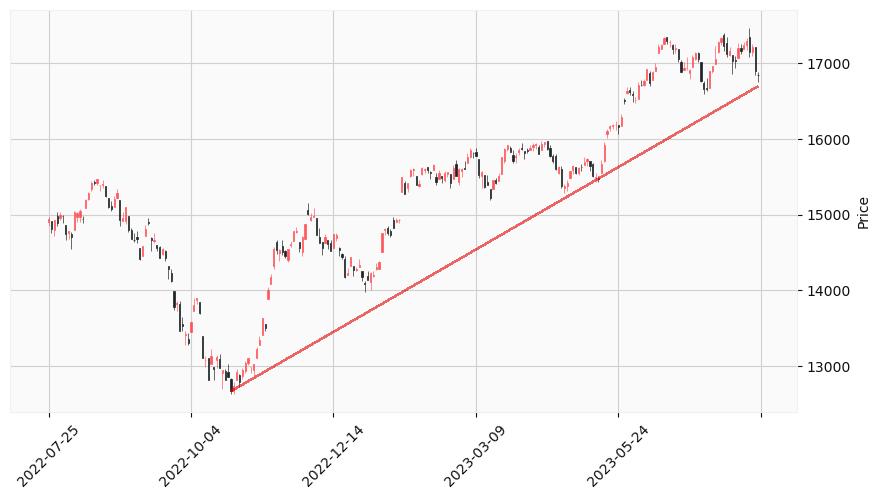

In [10]:
# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定上升趨勢線
seq_of_seq_of_points=[
    [(trendline_up_start_date,trendline_up_start_price),(trendline_up_end_date,trendline_up_end_price)]
                     ]

# 繪出K線圖
kwargs = dict(type='candle', style=s, figratio=(19,10), alines=dict(alines=seq_of_seq_of_points, linewidths=1.0, colors='xkcd:red', alpha=0.6), datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)